# 基于iTransformer的时间序列预测

In [15]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条
import math
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 多变量多步预测

### 数据准备

In [74]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [75]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [76]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [77]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [78]:
# 构造参数字典
params2 = {
    "lookback": 6,
    "delay": 3,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 1]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 1]),loader_len: 46


### 模型训练

In [121]:
def train(train_loader, valid_loader, n_epochs, verbose=True, plots=True):
    # 倒置编码
    class DataEmbedding_inverted(nn.Module):
        def __init__(self, seq_len, d_model, dropout=0.1):
            super(DataEmbedding_inverted, self).__init__()
            self.value_embedding = nn.Linear(seq_len, d_model)
            self.dropout = nn.Dropout(p=dropout)

        def forward(self, x, x_mark):
            x = x.permute(0, 2, 1)
            # x: [Batch Variate Time]
            if x_mark is None:
                x = self.value_embedding(x)
            else:
                x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
            # x: [Batch Variate d_model]
            return self.dropout(x)
        
    class EncoderLayer(nn.Module):
        def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
            super(EncoderLayer, self).__init__()
            d_ff = d_ff or 4 * d_model
            self.attention = attention
            self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
            self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
            self.dropout = nn.Dropout(dropout)
            self.activation = F.relu if activation == "relu" else F.gelu

        def forward(self, x, attn_mask=None, tau=None, delta=None):
            new_x, attn = self.attention(
                x, x, x,
                attn_mask=attn_mask,
                tau=tau, delta=delta
            )
            x = x + self.dropout(new_x)

            y = x = self.norm1(x)
            y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
            y = self.dropout(self.conv2(y).transpose(-1, 1))

            return self.norm2(x + y), attn


    class Encoder(nn.Module):
        def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
            super(Encoder, self).__init__()
            self.attn_layers = nn.ModuleList(attn_layers)
            self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
            self.norm = norm_layer

        def forward(self, x, attn_mask=None, tau=None, delta=None):
            # x [B, L, D]
            attns = []
            if self.conv_layers is not None:
                for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                    delta = delta if i == 0 else None
                    x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                    x = conv_layer(x)
                    attns.append(attn)
                x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
                attns.append(attn)
            else:
                for attn_layer in self.attn_layers:
                    x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                    attns.append(attn)

            if self.norm is not None:
                x = self.norm(x)

            return x, attns
        
    class FullAttention(nn.Module):
        def __init__(self, mask_flag=True, scale=None, attention_dropout=0.1, output_attention=False):
            super(FullAttention, self).__init__()
            self.scale = scale
            self.mask_flag = mask_flag
            self.output_attention = output_attention
            self.dropout = nn.Dropout(attention_dropout)

        def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
            B, L, H, E = queries.shape
            _, S, _, D = values.shape
            scale = self.scale or 1. / sqrt(E)

            scores = torch.einsum("blhe,bshe->bhls", queries, keys)

            if self.mask_flag:
                if attn_mask is None:
                    attn_mask = TriangularCausalMask(B, L, device=queries.device)

                scores.masked_fill_(attn_mask.mask, -np.inf)

            A = self.dropout(torch.softmax(scale * scores, dim=-1))
            V = torch.einsum("bhls,bshd->blhd", A, values)

            if self.output_attention:
                return V.contiguous(), A
            else:
                return V.contiguous(), None
            
    class AttentionLayer(nn.Module):
        def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
            super(AttentionLayer, self).__init__()

            d_keys = d_keys or (d_model // n_heads)
            d_values = d_values or (d_model // n_heads)

            self.inner_attention = attention
            self.query_projection = nn.Linear(d_model, d_keys * n_heads)
            self.key_projection = nn.Linear(d_model, d_keys * n_heads)
            self.value_projection = nn.Linear(d_model, d_values * n_heads)
            self.out_projection = nn.Linear(d_values * n_heads, d_model)
            self.n_heads = n_heads

        def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
            B, L, _ = queries.shape
            _, S, _ = keys.shape
            H = self.n_heads

            queries = self.query_projection(queries).view(B, L, H, -1)
            keys = self.key_projection(keys).view(B, S, H, -1)
            values = self.value_projection(values).view(B, S, H, -1)

            out, attn = self.inner_attention(
                queries,
                keys,
                values,
                attn_mask,
                tau=tau,
                delta=delta
            )
            out = out.view(B, L, -1)

            return self.out_projection(out), attn

    # iTransformer模型
    class iTransformer(nn.Module):
        def __init__(self, sequence_len, pred_len, output_attention, d_model, dropout, n_heads, d_ff, 
                     e_layers, activation):
            super(iTransformer, self).__init__()
            # 参数配置
            self.sequence_len = sequence_len # sequence_len输入时间步
            self.pred_len = pred_len # pred_len输出时间步
            self.output_attention = output_attention # 是否在ecoder中输出注意力
            
            # Embedding
            self.enc_embedding = DataEmbedding_inverted(sequence_len, d_model, dropout)
            
            # Encoder
            self.encoder = Encoder(
                [
                    EncoderLayer(
                        AttentionLayer(
                            FullAttention(False, attention_dropout=dropout,
                                          output_attention=output_attention), d_model, n_heads),
                        d_model, # 隐藏层数
                        d_ff, # ecoder中卷积层输出维度
                        dropout=dropout,
                        activation=activation # 激活函数
                    ) for l in range(e_layers) # encoder layers的层数
                ],
                norm_layer=torch.nn.LayerNorm(d_model)
            )
            
            # Decoder
            self.projection = nn.Linear(d_model, pred_len, bias=True)
            
        def forward(self, x_enc, x_mark_enc):
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

            _, _, N = x_enc.shape
#             print(N)

            # Embedding
            enc_out = self.enc_embedding(x_enc, x_mark_enc)
            
            enc_out, attns = self.encoder(enc_out, attn_mask=None)
#             print(enc_out.shape)
            dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :N]
#             print(dec_out.shape)
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            
            # output
            output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
            return output
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    itransformer_args = {
        'sequence_len': 2*3,
        'pred_len': 3,
        'output_attention': True,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 512,
        'dropout': 0,
        'e_layers': 1,
        'activation': "relu"}
    model = iTransformer(**itransformer_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    
    # 损失函数值
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch, None)
            outputs = outputs[:, :, :1] # 预测第一列的值，0代表第一列，1代表第二列
#             print(inputs_batch.shape)
#             print(targets_batch.shape)
#             print(outputs.shape)
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch, None)
                val_outputs = val_outputs[:, :, :1] # 取最后一个值
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  1%|▊                                                                                 | 1/100 [00:04<07:49,  4.74s/it]

Epoch [1/100], Training Loss: 0.0030, Validation Loss: 0.0041


  2%|█▋                                                                                | 2/100 [00:09<07:35,  4.65s/it]

Epoch [2/100], Training Loss: 0.0021, Validation Loss: 0.0040


  3%|██▍                                                                               | 3/100 [00:13<07:30,  4.64s/it]

Epoch [3/100], Training Loss: 0.0019, Validation Loss: 0.0033


  4%|███▎                                                                              | 4/100 [00:18<07:27,  4.66s/it]

Epoch [4/100], Training Loss: 0.0018, Validation Loss: 0.0031


  5%|████                                                                              | 5/100 [00:23<07:28,  4.72s/it]

Epoch [5/100], Training Loss: 0.0017, Validation Loss: 0.0030


  6%|████▉                                                                             | 6/100 [00:28<07:30,  4.79s/it]

Epoch [6/100], Training Loss: 0.0016, Validation Loss: 0.0031


  7%|█████▋                                                                            | 7/100 [00:33<07:23,  4.77s/it]

Epoch [7/100], Training Loss: 0.0016, Validation Loss: 0.0028


  8%|██████▌                                                                           | 8/100 [00:37<07:12,  4.70s/it]

Epoch [8/100], Training Loss: 0.0015, Validation Loss: 0.0031


  9%|███████▍                                                                          | 9/100 [00:42<07:05,  4.67s/it]

Epoch [9/100], Training Loss: 0.0015, Validation Loss: 0.0028


 10%|████████                                                                         | 10/100 [00:46<06:57,  4.64s/it]

Epoch [10/100], Training Loss: 0.0015, Validation Loss: 0.0028


 11%|████████▉                                                                        | 11/100 [00:51<06:53,  4.65s/it]

Epoch [11/100], Training Loss: 0.0014, Validation Loss: 0.0027


 12%|█████████▋                                                                       | 12/100 [00:56<06:48,  4.64s/it]

Epoch [12/100], Training Loss: 0.0014, Validation Loss: 0.0027


 13%|██████████▌                                                                      | 13/100 [01:00<06:38,  4.58s/it]

Epoch [13/100], Training Loss: 0.0013, Validation Loss: 0.0029


 14%|███████████▎                                                                     | 14/100 [01:05<06:29,  4.53s/it]

Epoch [14/100], Training Loss: 0.0014, Validation Loss: 0.0030


 15%|████████████▏                                                                    | 15/100 [01:09<06:22,  4.50s/it]

Epoch [15/100], Training Loss: 0.0015, Validation Loss: 0.0027


 16%|████████████▉                                                                    | 16/100 [01:13<06:15,  4.48s/it]

Epoch [16/100], Training Loss: 0.0013, Validation Loss: 0.0029


 17%|█████████████▊                                                                   | 17/100 [01:18<06:09,  4.45s/it]

Epoch [17/100], Training Loss: 0.0013, Validation Loss: 0.0031


 18%|██████████████▌                                                                  | 18/100 [01:22<06:04,  4.44s/it]

Epoch [18/100], Training Loss: 0.0013, Validation Loss: 0.0027


 19%|███████████████▍                                                                 | 19/100 [01:27<05:58,  4.43s/it]

Epoch [19/100], Training Loss: 0.0012, Validation Loss: 0.0029


 20%|████████████████▏                                                                | 20/100 [01:31<05:53,  4.42s/it]

Epoch [20/100], Training Loss: 0.0013, Validation Loss: 0.0025


 21%|█████████████████                                                                | 21/100 [01:35<05:48,  4.41s/it]

Epoch [21/100], Training Loss: 0.0012, Validation Loss: 0.0029


 22%|█████████████████▊                                                               | 22/100 [01:40<05:43,  4.41s/it]

Epoch [22/100], Training Loss: 0.0012, Validation Loss: 0.0023


 23%|██████████████████▋                                                              | 23/100 [01:44<05:39,  4.41s/it]

Epoch [23/100], Training Loss: 0.0012, Validation Loss: 0.0027


 24%|███████████████████▍                                                             | 24/100 [01:49<05:35,  4.41s/it]

Epoch [24/100], Training Loss: 0.0012, Validation Loss: 0.0030


 25%|████████████████████▎                                                            | 25/100 [01:53<05:30,  4.41s/it]

Epoch [25/100], Training Loss: 0.0012, Validation Loss: 0.0024


 26%|█████████████████████                                                            | 26/100 [01:57<05:24,  4.39s/it]

Epoch [26/100], Training Loss: 0.0012, Validation Loss: 0.0026


 27%|█████████████████████▊                                                           | 27/100 [02:01<05:09,  4.24s/it]

Epoch [27/100], Training Loss: 0.0012, Validation Loss: 0.0033


 28%|██████████████████████▋                                                          | 28/100 [02:05<05:00,  4.17s/it]

Epoch [28/100], Training Loss: 0.0014, Validation Loss: 0.0025


 29%|███████████████████████▍                                                         | 29/100 [02:09<04:51,  4.11s/it]

Epoch [29/100], Training Loss: 0.0012, Validation Loss: 0.0024


 30%|████████████████████████▎                                                        | 30/100 [02:13<04:43,  4.06s/it]

Epoch [30/100], Training Loss: 0.0011, Validation Loss: 0.0024


 31%|█████████████████████████                                                        | 31/100 [02:17<04:37,  4.02s/it]

Epoch [31/100], Training Loss: 0.0011, Validation Loss: 0.0030


 32%|█████████████████████████▉                                                       | 32/100 [02:21<04:32,  4.00s/it]

Epoch [32/100], Training Loss: 0.0011, Validation Loss: 0.0026


 33%|██████████████████████████▋                                                      | 33/100 [02:25<04:27,  3.99s/it]

Epoch [33/100], Training Loss: 0.0012, Validation Loss: 0.0027


 34%|███████████████████████████▌                                                     | 34/100 [02:29<04:21,  3.96s/it]

Epoch [34/100], Training Loss: 0.0011, Validation Loss: 0.0028


 35%|████████████████████████████▎                                                    | 35/100 [02:33<04:18,  3.98s/it]

Epoch [35/100], Training Loss: 0.0011, Validation Loss: 0.0026


 36%|█████████████████████████████▏                                                   | 36/100 [02:37<04:18,  4.04s/it]

Epoch [36/100], Training Loss: 0.0011, Validation Loss: 0.0025


 37%|█████████████████████████████▉                                                   | 37/100 [02:41<04:14,  4.04s/it]

Epoch [37/100], Training Loss: 0.0011, Validation Loss: 0.0032


 38%|██████████████████████████████▊                                                  | 38/100 [02:45<04:09,  4.03s/it]

Epoch [38/100], Training Loss: 0.0011, Validation Loss: 0.0027


 39%|███████████████████████████████▌                                                 | 39/100 [02:49<04:06,  4.04s/it]

Epoch [39/100], Training Loss: 0.0011, Validation Loss: 0.0031


 40%|████████████████████████████████▍                                                | 40/100 [02:53<04:02,  4.04s/it]

Epoch [40/100], Training Loss: 0.0011, Validation Loss: 0.0030


 41%|█████████████████████████████████▏                                               | 41/100 [02:57<03:58,  4.04s/it]

Epoch [41/100], Training Loss: 0.0011, Validation Loss: 0.0026


 42%|██████████████████████████████████                                               | 42/100 [03:01<03:56,  4.07s/it]

Epoch [42/100], Training Loss: 0.0010, Validation Loss: 0.0024


 43%|██████████████████████████████████▊                                              | 43/100 [03:05<03:51,  4.07s/it]

Epoch [43/100], Training Loss: 0.0011, Validation Loss: 0.0027


 44%|███████████████████████████████████▋                                             | 44/100 [03:10<03:50,  4.12s/it]

Epoch [44/100], Training Loss: 0.0011, Validation Loss: 0.0028


 45%|████████████████████████████████████▍                                            | 45/100 [03:14<03:45,  4.10s/it]

Epoch [45/100], Training Loss: 0.0011, Validation Loss: 0.0024


 46%|█████████████████████████████████████▎                                           | 46/100 [03:18<03:41,  4.09s/it]

Epoch [46/100], Training Loss: 0.0011, Validation Loss: 0.0028


 47%|██████████████████████████████████████                                           | 47/100 [03:22<03:37,  4.09s/it]

Epoch [47/100], Training Loss: 0.0010, Validation Loss: 0.0024


 48%|██████████████████████████████████████▉                                          | 48/100 [03:26<03:31,  4.08s/it]

Epoch [48/100], Training Loss: 0.0010, Validation Loss: 0.0024


 49%|███████████████████████████████████████▋                                         | 49/100 [03:30<03:26,  4.05s/it]

Epoch [49/100], Training Loss: 0.0011, Validation Loss: 0.0024


 50%|████████████████████████████████████████▌                                        | 50/100 [03:34<03:23,  4.08s/it]

Epoch [50/100], Training Loss: 0.0010, Validation Loss: 0.0023


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:38<03:19,  4.07s/it]

Epoch [51/100], Training Loss: 0.0010, Validation Loss: 0.0024


 52%|██████████████████████████████████████████                                       | 52/100 [03:42<03:15,  4.07s/it]

Epoch [52/100], Training Loss: 0.0010, Validation Loss: 0.0026


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:46<03:12,  4.09s/it]

Epoch [53/100], Training Loss: 0.0011, Validation Loss: 0.0028


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:51<03:09,  4.12s/it]

Epoch [54/100], Training Loss: 0.0010, Validation Loss: 0.0023


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:55<03:04,  4.10s/it]

Epoch [55/100], Training Loss: 0.0010, Validation Loss: 0.0027


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:59<03:00,  4.10s/it]

Epoch [56/100], Training Loss: 0.0010, Validation Loss: 0.0026


 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:03<02:56,  4.10s/it]

Epoch [57/100], Training Loss: 0.0010, Validation Loss: 0.0025


 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:07<02:52,  4.11s/it]

Epoch [58/100], Training Loss: 0.0010, Validation Loss: 0.0023


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:11<02:49,  4.12s/it]

Epoch [59/100], Training Loss: 0.0010, Validation Loss: 0.0028


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:15<02:47,  4.18s/it]

Epoch [60/100], Training Loss: 0.0010, Validation Loss: 0.0028


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:20<02:42,  4.17s/it]

Epoch [61/100], Training Loss: 0.0011, Validation Loss: 0.0025


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:24<02:38,  4.18s/it]

Epoch [62/100], Training Loss: 0.0010, Validation Loss: 0.0024


 63%|███████████████████████████████████████████████████                              | 63/100 [04:28<02:33,  4.15s/it]

Epoch [63/100], Training Loss: 0.0010, Validation Loss: 0.0024


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:32<02:30,  4.17s/it]

Epoch [64/100], Training Loss: 0.0009, Validation Loss: 0.0026


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:36<02:25,  4.15s/it]

Epoch [65/100], Training Loss: 0.0009, Validation Loss: 0.0024


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:40<02:20,  4.15s/it]

Epoch [66/100], Training Loss: 0.0010, Validation Loss: 0.0026


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:45<02:18,  4.19s/it]

Epoch [67/100], Training Loss: 0.0009, Validation Loss: 0.0026


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:49<02:14,  4.20s/it]

Epoch [68/100], Training Loss: 0.0009, Validation Loss: 0.0024


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:53<02:09,  4.19s/it]

Epoch [69/100], Training Loss: 0.0009, Validation Loss: 0.0026


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:57<02:06,  4.20s/it]

Epoch [70/100], Training Loss: 0.0010, Validation Loss: 0.0024


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:02<02:02,  4.24s/it]

Epoch [71/100], Training Loss: 0.0009, Validation Loss: 0.0025


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:06<01:58,  4.23s/it]

Epoch [72/100], Training Loss: 0.0009, Validation Loss: 0.0025


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:10<01:56,  4.30s/it]

Epoch [73/100], Training Loss: 0.0009, Validation Loss: 0.0026


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:14<01:51,  4.29s/it]

Epoch [74/100], Training Loss: 0.0009, Validation Loss: 0.0025


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:19<01:46,  4.28s/it]

Epoch [75/100], Training Loss: 0.0009, Validation Loss: 0.0024


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:23<01:42,  4.27s/it]

Epoch [76/100], Training Loss: 0.0009, Validation Loss: 0.0024


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:27<01:37,  4.24s/it]

Epoch [77/100], Training Loss: 0.0009, Validation Loss: 0.0028


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:31<01:33,  4.25s/it]

Epoch [78/100], Training Loss: 0.0009, Validation Loss: 0.0024


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:36<01:29,  4.24s/it]

Epoch [79/100], Training Loss: 0.0009, Validation Loss: 0.0025


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:40<01:25,  4.26s/it]

Epoch [80/100], Training Loss: 0.0009, Validation Loss: 0.0025


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:44<01:20,  4.26s/it]

Epoch [81/100], Training Loss: 0.0009, Validation Loss: 0.0023


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:48<01:16,  4.26s/it]

Epoch [82/100], Training Loss: 0.0009, Validation Loss: 0.0025


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:53<01:12,  4.25s/it]

Epoch [83/100], Training Loss: 0.0009, Validation Loss: 0.0023


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:57<01:08,  4.26s/it]

Epoch [84/100], Training Loss: 0.0009, Validation Loss: 0.0030


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:01<01:04,  4.30s/it]

Epoch [85/100], Training Loss: 0.0009, Validation Loss: 0.0024


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:06<01:01,  4.41s/it]

Epoch [86/100], Training Loss: 0.0009, Validation Loss: 0.0029


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:10<00:56,  4.35s/it]

Epoch [87/100], Training Loss: 0.0009, Validation Loss: 0.0025


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:15<00:51,  4.33s/it]

Epoch [88/100], Training Loss: 0.0008, Validation Loss: 0.0028


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:19<00:47,  4.33s/it]

Epoch [89/100], Training Loss: 0.0008, Validation Loss: 0.0025


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:23<00:43,  4.32s/it]

Epoch [90/100], Training Loss: 0.0009, Validation Loss: 0.0027


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:27<00:38,  4.29s/it]

Epoch [91/100], Training Loss: 0.0008, Validation Loss: 0.0025


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:32<00:34,  4.30s/it]

Epoch [92/100], Training Loss: 0.0008, Validation Loss: 0.0024


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:36<00:30,  4.29s/it]

Epoch [93/100], Training Loss: 0.0008, Validation Loss: 0.0027


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:40<00:25,  4.26s/it]

Epoch [94/100], Training Loss: 0.0009, Validation Loss: 0.0024


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:44<00:21,  4.26s/it]

Epoch [95/100], Training Loss: 0.0008, Validation Loss: 0.0026


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:49<00:17,  4.28s/it]

Epoch [96/100], Training Loss: 0.0009, Validation Loss: 0.0049


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:53<00:12,  4.28s/it]

Epoch [97/100], Training Loss: 0.0010, Validation Loss: 0.0027


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:57<00:08,  4.27s/it]

Epoch [98/100], Training Loss: 0.0008, Validation Loss: 0.0025


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:02<00:04,  4.26s/it]

Epoch [99/100], Training Loss: 0.0009, Validation Loss: 0.0024


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:06<00:00,  4.26s/it]

Epoch [100/100], Training Loss: 0.0008, Validation Loss: 0.0024


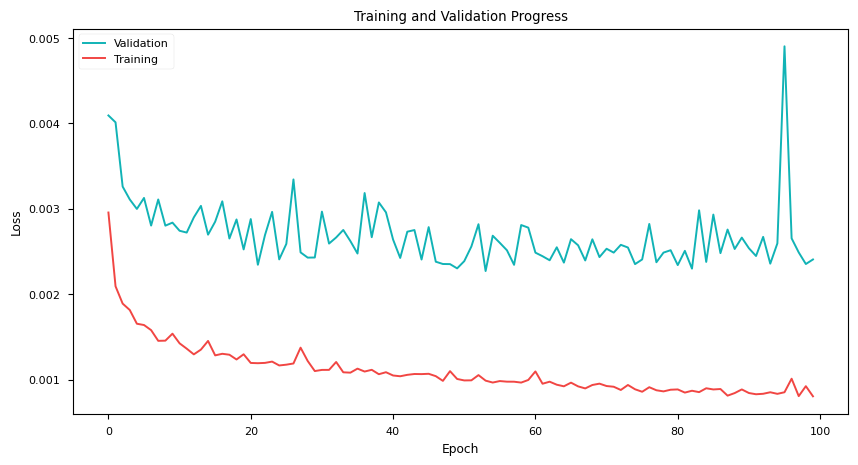

In [122]:
# 构造参数字典
params3 = {
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "n_epochs": 100,
    "verbose": True,
    "plots": True,
}
model = train(**params3)

### 模型预测

"SMAPE loss" 是指 Symmetric Mean Absolute Percentage Error，中文意为对称平均绝对百分比误差。这是一种用于衡量预测模型精度的指标，通常用于评估时间序列预测模型的性能。

SMAPE 的计算公式如下：

\$
SMAPE = \frac{100\%}{n} \sum_{t=1}^{n} \frac{|F_t - A_t|}{(|F_t| + |A_t|)/2}
\$

其中：

- \(F_t\) 是模型预测的值；
- \(A_t\) 是实际观测到的值；
- \(n\) 是样本数量。

SMAPE 通常被用作损失函数，用于优化时间序列预测模型。在优化过程中，目标是尽量减小 SMAPE 损失，以提高模型的预测准确性。

In [ ]:
#     # 损失函数
#     class smape_loss(nn.Module):
#         def __init__(self):
#             super(smape_loss, self).__init__()
            
#         def divide_no_nan(self, a, b):
#             """
#             a/b where the resulted NaN or Inf are replaced by 0.
#             """
#             result = a / b
#             result[result != result] = .0
#             result[result == np.inf] = .0
#             return result

#         def forward(self, forecast: torch.Tensor, target: torch.Tensor) -> torch.float:
#             """
#             sMAPE loss as defined in https://robjhyndman.com/hyndsight/smape/ (Makridakis 1993)

#             :param forecast: Forecast values. Shape: batch, time
#             :param target: Target values. Shape: batch, time
#             :param mask: 0/1 mask. Shape: batch, time
#             :return: Loss value
#             """
#             return 200 * torch.mean(self.divide_no_nan(torch.abs(forecast - target),
#                                               torch.abs(forecast.data) + torch.abs(target.data)))

In [123]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, y_feature_list, lookback, delay, scaler, in_tag):
    lookback = lookback - 1 # 包含当前时间点
    features = y_train.shape[-1] # 预测特征数
    
    # 字典索引生成
    col_dict = {}
    for i,j in enumerate(y_feature_list):
        col_dict[j] = i
        
    # 数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    # 时间序列形状
    timeseries_y = y_true.values[:, col_dict[in_tag]].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train, None)
        y_pred = y_pred[:, 0, :1].reshape(-1, features) # 0表示第一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列，单输出时默认为0
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid, None)
        y_pred = y_pred[:, 0, :1].reshape(-1, features)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test, None)
        y_pred = y_pred[:, 0, :1].reshape(-1, features)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [124]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data,
    "y_feature_list": ['load'],
    "lookback": 6,
    "delay": 3,
    "scaler": scaler,
    "in_tag": 'load'
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

### 结果分析

In [125]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

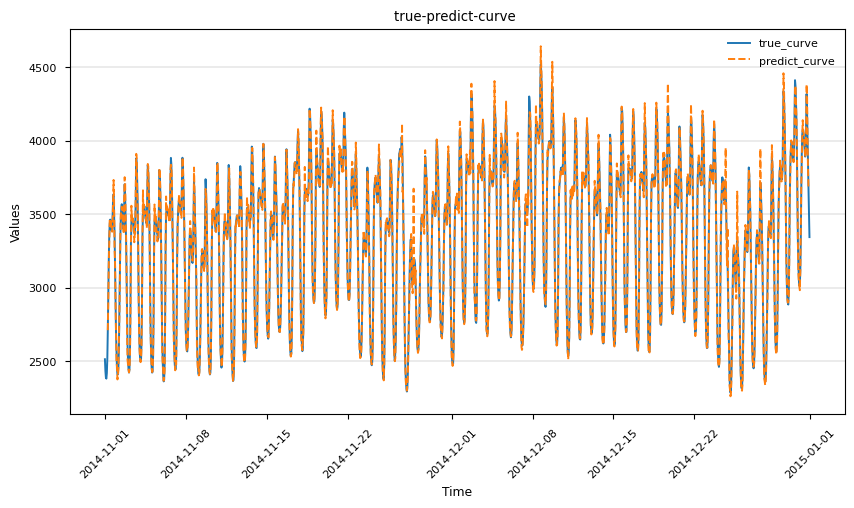

In [126]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)